# 1) Imports

In [120]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# 2) Data Loading and Preparation
### This section loads the sales data, parses dates, and prepares it for analysis by setting the appropriate index and grouping by family and date.

In [141]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

family_sales.head(3)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   

                                                                        \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS    PRODUCE   
date                                                                     
2017-01-01                     0.0  0.000000       0.037037   0.129630   
2017-01-02                     0.0  0.259259       1.166667   5.629630   
2017-01-03                     0.0  0.388889       1.351852  56.296296   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  

[3 rows x 66 columns]

School and office supplies is known to have strong cyclic behaviour

# 3) Baseline Model
### This section introduces the baseline model which uses only seasonal and cyclic features.

### 3.1 Deseasonalize the Series
Deseasonalizing the sales data to remove seasonal effects and isolate cyclic patterns.



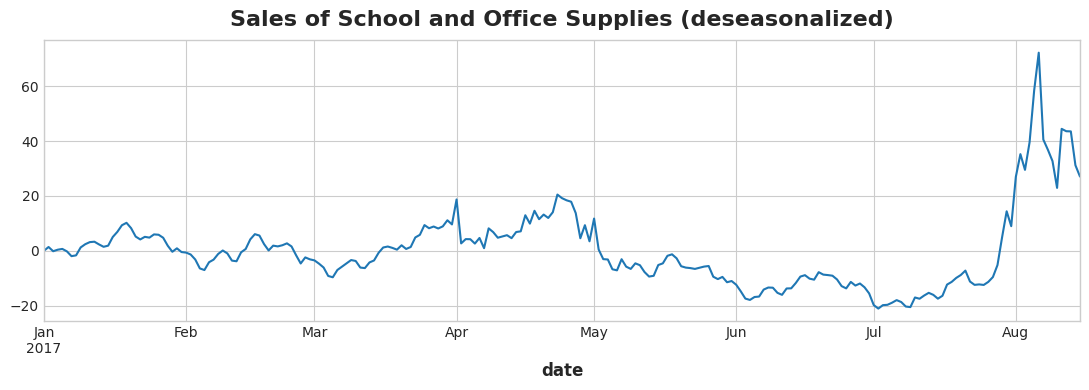

In [122]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample() #generate in sample design matrix with time related variables
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");


### 3.2 Analyze Moving Average for Cyclicality
Analyze the moving average to understand the cyclic behavior in the sales data.



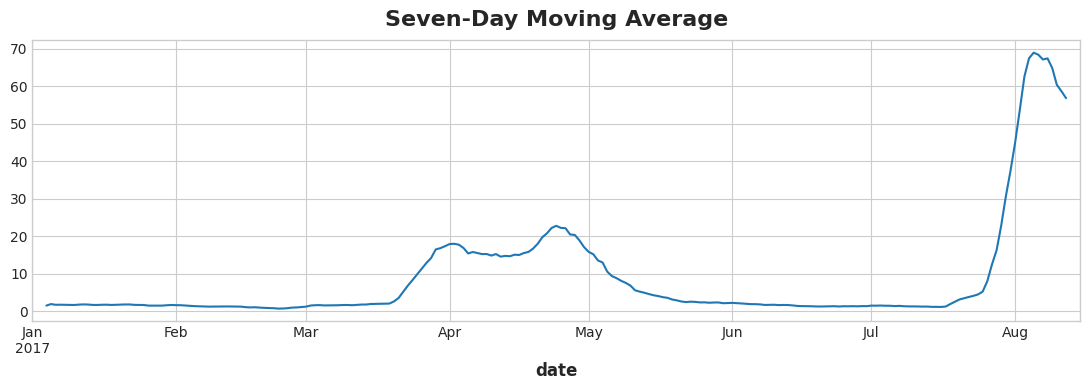

In [123]:
y_ma = y.rolling(7, center=True).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

Notice that the 7 day moving average of the original sales data is similar to the deseasonalized sales plot. This suggests that sales patterns are primarily driven by the cycles, rather than just the seasonal trends, making cyclicality the more prominent characteristic in this time series

### 3.3 Train Baseline Model (Only Seasonal and Cyclic Features)

Train the baseline model using only the seasonal and cyclic features derived from the Fourier series.

Baseline Training RMSLE: 0.88620
Baseline Validation RMSLE: 1.68564


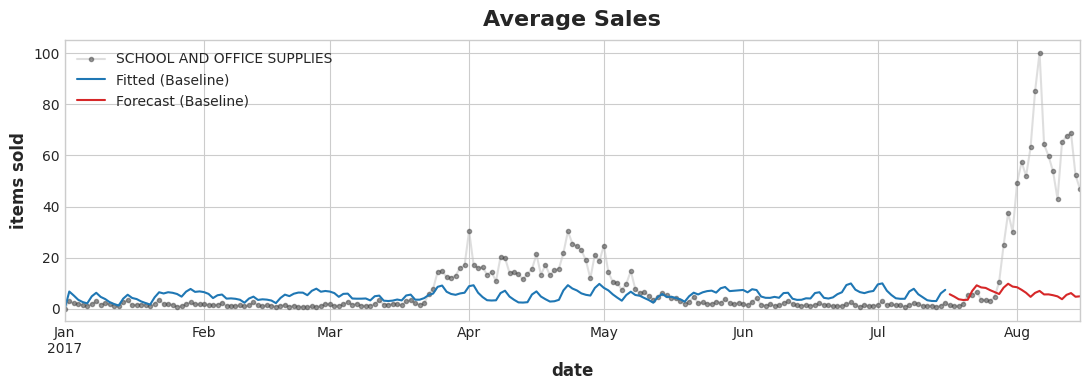

In [124]:
from sklearn.model_selection import train_test_split

X = X_time

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

baseline_model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit_baseline = pd.Series(baseline_model.predict(X_train), index=X_train.index).clip(0.0)
y_pred_baseline = pd.Series(baseline_model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train_baseline = mean_squared_log_error(y_train, y_fit_baseline) ** 0.5
rmsle_valid_baseline = mean_squared_log_error(y_valid, y_pred_baseline) ** 0.5
print(f'Baseline Training RMSLE: {rmsle_train_baseline:.5f}')
print(f'Baseline Validation RMSLE: {rmsle_valid_baseline:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_baseline.plot(ax=ax, label="Fitted (Baseline)", color='C0')
ax = y_pred_baseline.plot(ax=ax, label="Forecast (Baseline)", color='C3')
ax.legend();


The baseline model, using only seasonal and cyclic features, shows some ability to capture the peaks and troughs in the sales data. However, the predictions are not very accurate (not at all), indicating a weak model. This suggests that additional features are needed to improve the forecast accuracy.

# 4) Improving the Model
### This section focuses on improving the model by incorporating lag features to capture serial dependence.

### 4.1 Examine Serial Dependence with Partial Autocorrelation and Lag Plots
Examine the serial dependence in the deseasonalized series using lag plots and partial autocorrelation plots.

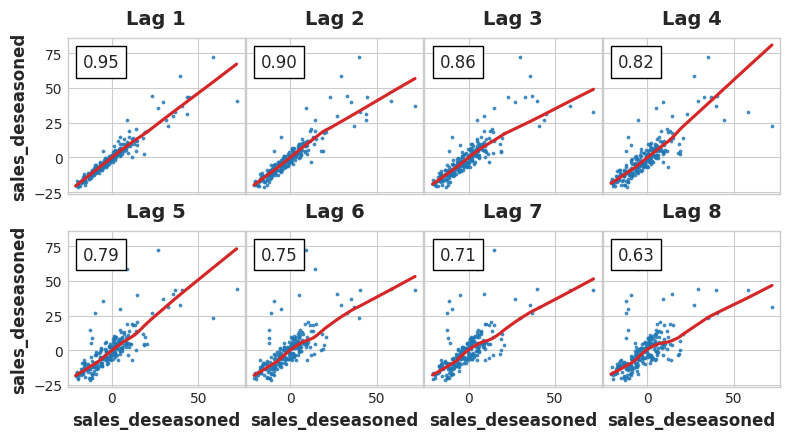

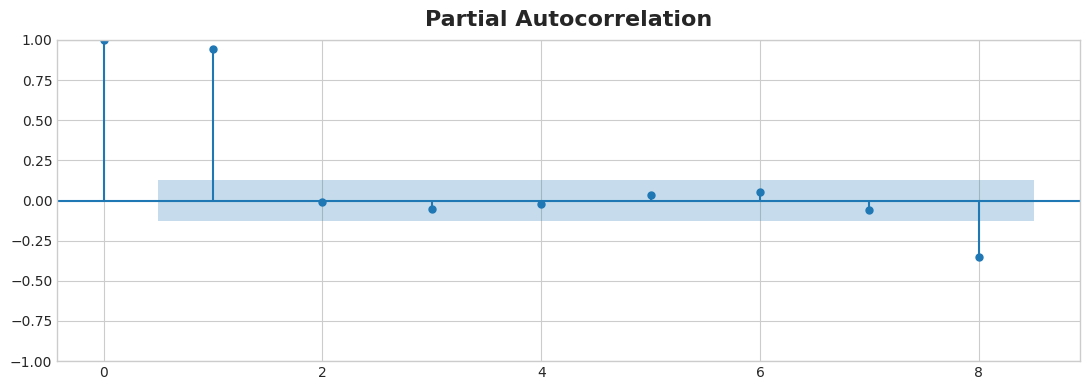

In [139]:
#focusing on the deseasonalized series to determine serial dependence
plot_lags(y_deseason, lags=8, nrows=2);
plot_pacf(y_deseason, lags=8);

The lag plots reveal strong linear relationships between the deseasonalized sales and its past values up to lag 8, indicating significant serial dependence. Specifically, lags 1 and 2 show the highest correlations. 

The partial autocorrelation plot confirms that lags 1 and 8 are the most significant when accounting for the influence of previous lags, suggesting that these should be included as features in the improved model to accurately capture the serial dependence and improve forecast accuracy.

In [135]:
def create_features(y):
    y_lag_1 = y.shift(1)
    #y_lag_2 = y.shift(2)
    #y_lag_8 = y.shift(8)  #found that just lag 1 yields more accuracy
    #median_14 = y.rolling(14).median() #feature yields worse model
    #std_7 = y.rolling(7).std() #feature yields worse model
    return pd.concat([y_lag_1], axis=1)

X_lags = create_features(y_deseason)
X = pd.concat([X_time, X_lags], axis=1).dropna()
y, X = y.align(X, join='inner')

X.head()


,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",NewYearsDay,sales_deseasoned
date,,,,,,,,,,,,,,,,,,
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False,1.362820
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False,-0.172481
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False,0.377727
2017-01-06,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.848644,0.528964,0.897805,-0.440394,0.101168,-0.994869,-0.790776,-0.612106,False,0.665153
2017-01-07,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.937752,0.347305,0.651372,-0.758758,-0.485302,-0.874347,-0.988468,0.151428,False,-0.231810


Improved Training RMSLE: 0.31966
Improved Validation RMSLE: 0.39642


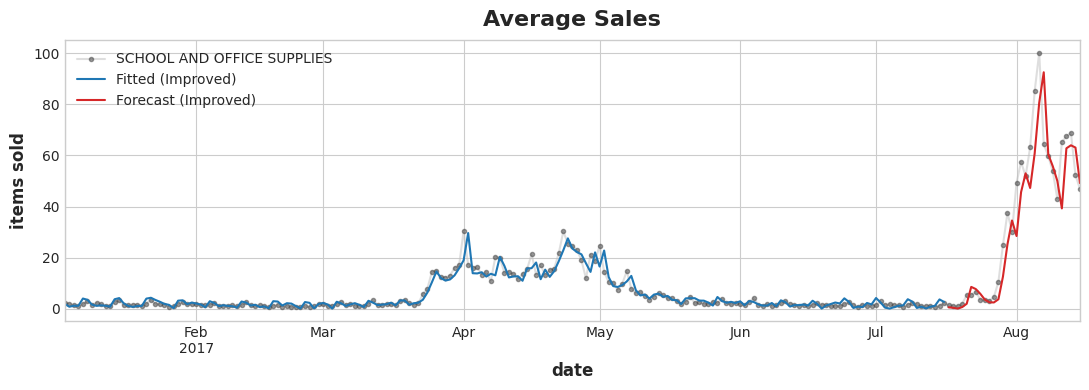

In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

improved_model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit_improved = pd.Series(improved_model.predict(X_train), index=X_train.index).clip(0.0)
y_pred_improved = pd.Series(improved_model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train_improved = mean_squared_log_error(y_train, y_fit_improved) ** 0.5
rmsle_valid_improved = mean_squared_log_error(y_valid, y_pred_improved) ** 0.5
print(f'Improved Training RMSLE: {rmsle_train_improved:.5f}')
print(f'Improved Validation RMSLE: {rmsle_valid_improved:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_improved.plot(ax=ax, label="Fitted (Improved)", color='C0')
ax = y_pred_improved.plot(ax=ax, label="Forecast (Improved)", color='C3')
ax.legend();


In [138]:
print(f'Baseline Training RMSLE: {rmsle_train_baseline:.5f}')
print(f'Baseline Validation RMSLE: {rmsle_valid_baseline:.5f}')
print(f'Improved Training RMSLE: {rmsle_train_improved:.5f}')
print(f'Improved Validation RMSLE: {rmsle_valid_improved:.5f}')

Baseline Training RMSLE: 0.88620
Baseline Validation RMSLE: 1.68564
Improved Training RMSLE: 0.31966
Improved Validation RMSLE: 0.39642


The analysis began with the creation of a **baseline model** using only **seasonal** and **cyclic features** derived from the **Fourier series** and **calendar effects**. The baseline model demonstrated a **moderate ability** to capture the overall sales pattern but fell short in **predictive accuracy**, as evidenced by high **RMSLE values** on both the **training** and **validation sets** (0.88620 and 1.68564, respectively), and as well as the plot.

To enhance the model, we investigated the **deseasonalized sales data** for **serial dependence**. The analysis involved plotting the **seven-day moving average**, which showed a pattern similar to the deseasonalized sales data. This similarity suggested that **cyclicality** was a prominent characteristic driving the sales patterns, rather than just seasonal trends.

Further analysis using **lag plots** and **partial autocorrelation plots** provided deeper insights. The lag plots indicated strong linear relationships between the deseasonalized sales and its past values up to lag 8, with **lags 1 and 2** showing the highest correlations. The partial autocorrelation plot confirmed that **lags 1 and 8** were statistically significant, implying that these lags should be considered as features to capture the serial dependence effectively.

Based on these findings, we introduced a **single lag feature** (lag 1) into the model. The inclusion of this lag feature led to a substantial improvement in model performance, highlighting the significance of serial dependence in this time series data. The improved model achieved significantly lower RMSLE values: **0.31966** on the training set and **0.39642** on the validation set.

This outcome illustrates the critical role that serial dependence plays in time series forecasting. The significant improvement from adding just one lag feature underscores how certain time series inherently possess this property, which, when leveraged appropriately, can greatly enhance predictive accuracy.